In [ ]:
from USTs import USTs
from DataFetcher import DataFetcher
import datetime
from scipy.optimize import newton
import pandas as pd
import requests
from bs4 import BeautifulSoup
import requests
from dateutil.relativedelta import relativedelta
from Curves import ParCurves
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
CUSIPs = ['912810RB6', '912810SR0']
START = datetime.date(2025, 1, 1)
END = datetime.date(2025, 6, 30)
# USTs(None, None).get_cusip_timeseries(cusips, datetime.date(2025, 1, 1), datetime.date(2025, 6, 30))

In [ ]:
usts = USTs(date=datetime.date(2025, 6, 30))
ust_set = usts.get_current_UST_set(settlement_date=datetime.datetime(2025, 7, 1),
                                   get_ytms=True,
                                   include_FRNs=False,
                                   include_TIPS=False,
                                   include_outstanding=False)

Merged auction and price data successfully
No missing or excess data
All CUSIPs are identical between DataFrames


In [85]:
screening_df = usts.get_initial_screening_set()
screening_df

,Duration exposure,Current spread,Par curve spread,Long bond,Tenor,YTM,Short bond,Tenor,YTM
0,Long duration,10.9 bps,0.5 bps,2.875% May-43,30-Year,4.871714,1.125% May-40,20-Year,4.762699
1,Long duration,10.6 bps,1.7 bps,3.125% Aug-44,30-Year,4.898658,1.375% Nov-40,20-Year,4.792920
2,Long duration,10.5 bps,2.0 bps,4.375% Nov-39,30-Year,4.638023,3.500% Feb-39,30-Year,4.532958
3,Long duration,16.9 bps,9.0 bps,4.750% Feb-41,30-Year,4.701868,3.500% Feb-39,30-Year,4.532958
4,Long duration,10.7 bps,4.4 bps,3.125% Aug-44,30-Year,4.898658,1.875% Feb-41,20-Year,4.791372


In [ ]:
date_range = pd.date_range(START, END).to_list()
valid_dates = []
for date in date_range:
    if not (date.date().weekday() in [5, 6]) or (date.date() in usts.holidays):
        valid_dates.append(datetime.datetime(date.year, date.month, date.day))

auction_data = usts.auction_data
all_data = {}
for date in valid_dates:
    price_data = DataFetcher().fetch_historical_UST_data(date.date())
    if price_data is not None:
        price_data = price_data[price_data['Security type'] != 'Bill']
        settlement = usts.adjust_for_bad_day(date + relativedelta(days=1))
        print(date, settlement)
        full_date_data = usts.get_current_UST_set(settlement_date=settlement,
                                                auction_data=auction_data,
                                                price_data=price_data)
        all_data[date] = full_date_data


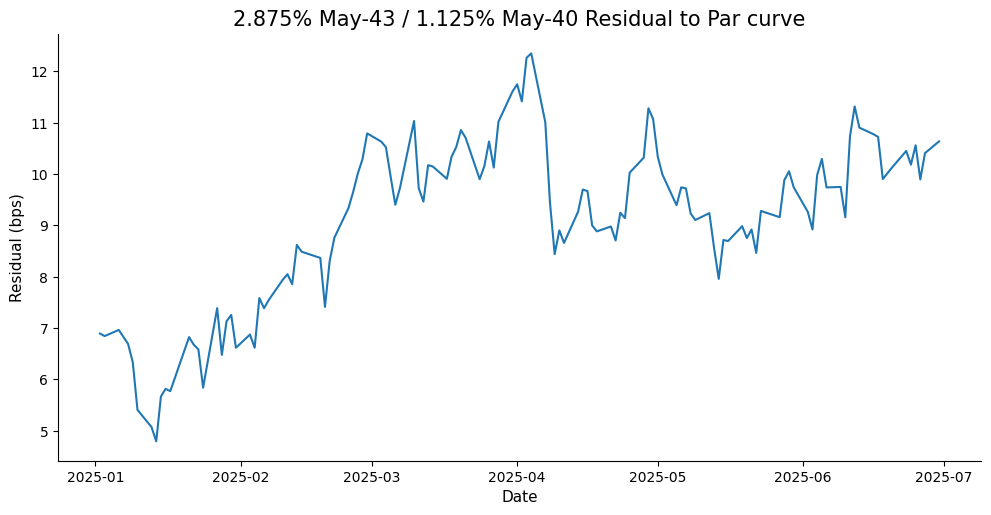

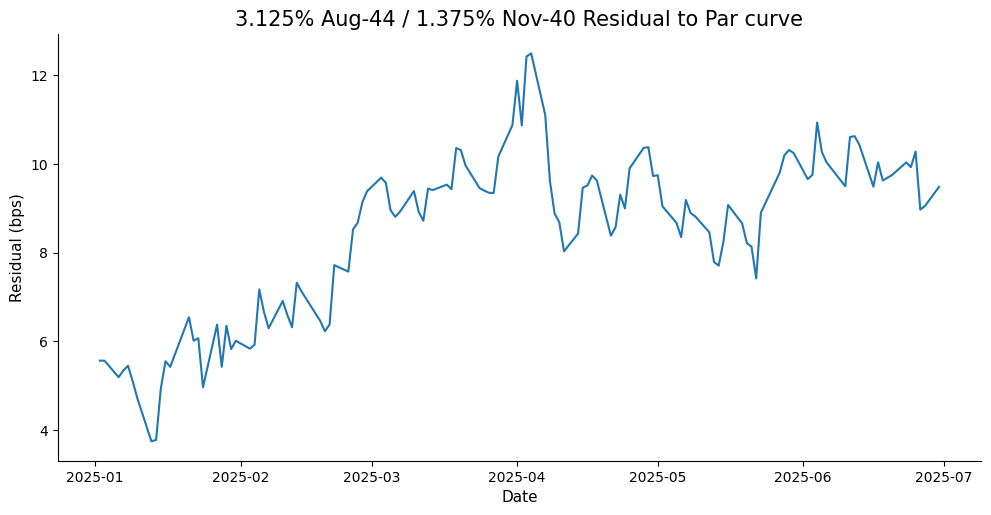

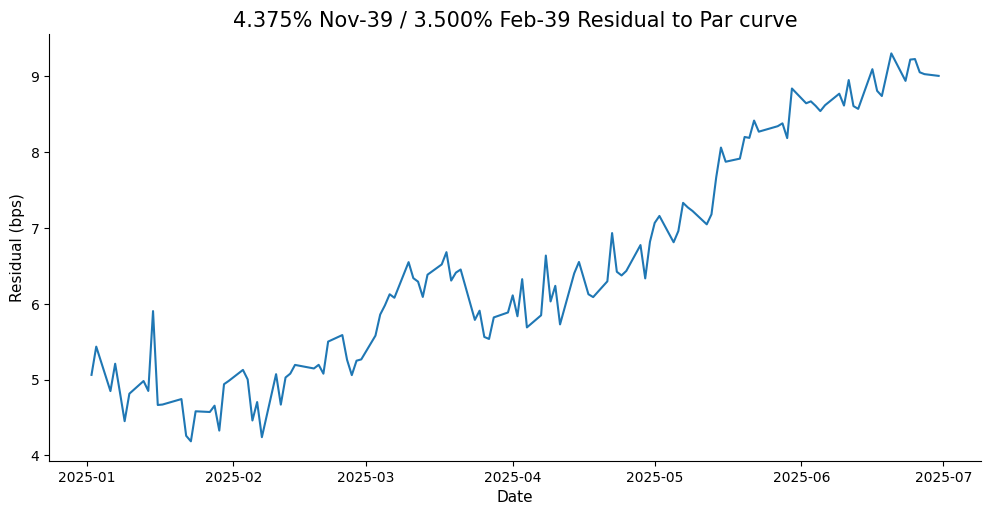

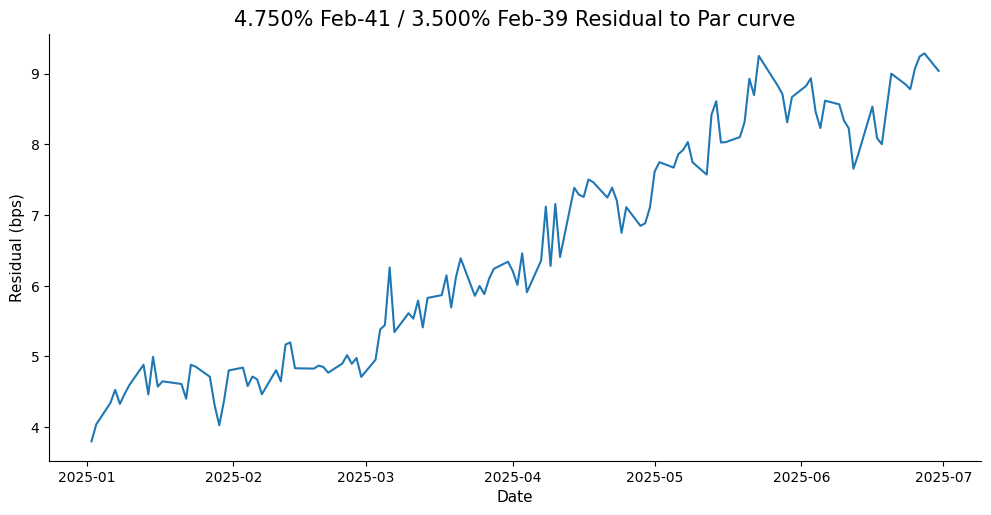

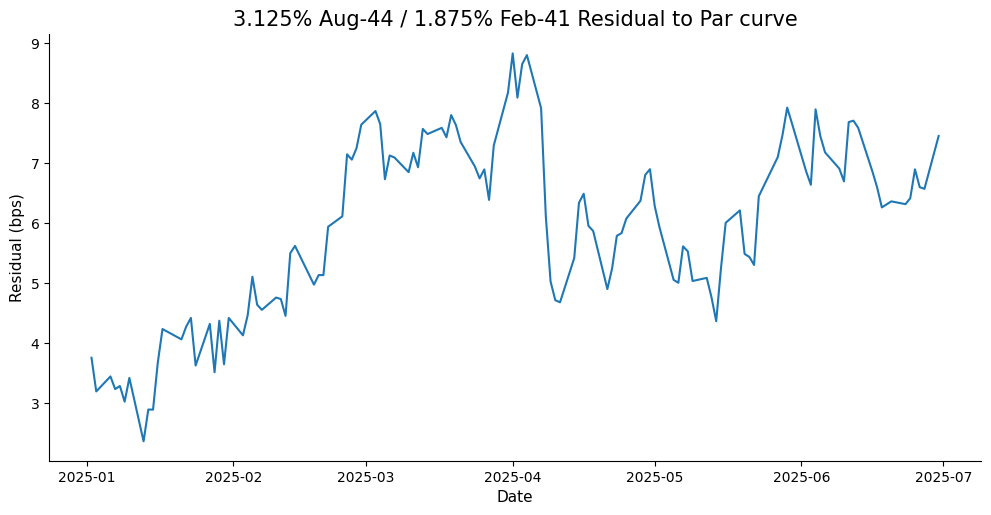

In [106]:
trade_set = usts.trade_screening_set
for i in range(len(trade_set)):
    trade_row = trade_set.iloc[i, :]
    cusips = [usts._get_cusip_from_label(trade_row['Long bond']), usts._get_cusip_from_label(trade_row['Short bond'])]
    spread_df = pd.DataFrame(columns=['Long bond yield', 'Short bond yield', 'Spread', 'Par curve spread'])
    for key in all_data.keys():
        df = all_data[key]
        filtered_set = df[(df['Years to maturity'] > 90/365) & (df['Security type'] != 'Bill') & (df['Rank'] > 2)]
        bspline_model = ParCurves(filtered_set).Bspline_with_knots(knots=[0.5, 1, 2, 3, 5, 7, 8, 9, 10, 15, 20, 25],
                                                                   return_data=False)
        otr_set = df[df['Rank'] == 1]
        interpolator = scipy.interpolate.interp1d(
            x=otr_set['Duration'],
            y=otr_set['Years to maturity'],
            kind='cubic',
            fill_value='extrapolate')
        long_tenor, short_tenor = float(interpolator(trade_row['Duration long'])), float(interpolator(trade_row['Duration short']))
        par_spread = float(bspline_model(long_tenor) - bspline_model(short_tenor))
        long_yield = all_data[key].loc[cusips[0], 'EOD YTM']
        short_yield = all_data[key].loc[cusips[1], 'EOD YTM']
        long_duration, short_duration = trade_row['Duration long'], trade_row['Duration short']
        spread_df.loc[key] = [long_yield, short_yield, long_yield-short_yield, par_spread]
    spread_df['Par curve residual'] = (spread_df['Spread'] - spread_df['Par curve spread'])*100
    sns.relplot(data=spread_df, x=spread_df.index, y='Par curve residual', kind='line', aspect=2)
    plt.title(f"{trade_row['Long bond']} / {trade_row['Short bond']} Residual to Par curve", fontdict={'size': 15,
                                                                                                       'weight': 'normal',
                                                                                                       'family': 'sans-serif'})
    plt.ylabel("Residual (bps)", fontdict={'size':11})
    plt.xlabel('Date', fontdict={'size':11})
    plt.show()
